<a id='home'></a>
## purpose 
    
    use PCA to assign populations to groups using k-means clustering
    

## outline

1. [read in snps](#snps)
1. [use k-means clustering to determine population color](#kmeans)
    - Run pca, choose number of axes (based on % variance explained) to use in k-means clustering
    - run k-means clustering for k in {1..21}, choose optimal k based on silhouette method + elbow rule
    - plot populations on map using PCA group colors
    - compare to pca with imputed data
1. [save](#save)
    
    
    
__conclusion__ : 

    • 3 PCA axes were used, and the optimal number of PCA groups was 4 for both no-missing and imputed data

In [1]:
from pythonimports import *
from matplotlib.colors import rgb2hex, colorConverter
import matplotlib.colors as mcolors
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pcadir = makedir('/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/\
without_p24/03_maf-p05_RD-recalculated/pca')

envfile = "/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_std_env-19variables.txt"

# imputed via mean freq from 4 nearest neighbors in yeaman03:/notebooks/007_JP_gea/05_RDA/001_RDA_jack_pine
freqfile = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/\
03_maf-p05_RD-recalculated/rda/\
JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated_IMPUTED_nontransposed.pkl'

lview,dview = get_client()

56 56


In [2]:
latest_commit()
sinfo(html=True)

##################################################################
Current commit of pythonimports:
commit 3a4b7edd94791192e01088623ade64a0a79f4b39
Author: Brandon Lind <lindb@vcu.edu>
Date:   Tue Mar 23 14:07:40 2021 -0400
Today:	March 30, 2021 - 13:34:22
python version: 3.8.5
##################################################################



<a id='snps'></a>
# read in SNPs and population colors

[top](#home)

In [3]:
# map arbitrary pca group to a color, for plotting
coldict = {'first': 'blue',
           'second': 'green',
           'third': 'darkorange',
           'fourth': 'magenta',
           'fifth': 'yellow',
           'sixth': 'saddlebrown',
           'seventh': 'darkgreen',
           'eighth': 'gold',
           'nineth': 'aqua',
           'tenth': 'blueviolet',
           'eleventh': 'pink',
           'twelfth': 'black'}
for group,color in coldict.items():
    print(ColorText(group).custom(color).bold(), end=' ')
print('\n')

first second third fourth fifth sixth seventh eighth nineth tenth eleventh twelfth 



In [4]:
# read in envdata for lat/long
envdata = pd.read_table(envfile)
envdata.index = envdata['our_id'].tolist()
envdata.head(2)

,id1,id2,our_id,LAT,LONG,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group_color
JP_p98,9150251,38,JP_p98,54.3333,-106.6333,537,0.675175,0.520607,-0.903668,1.089738,-0.977280,-0.426821,-0.730607,-0.884497,-1.150172,-1.078601,-0.980098,-1.159142,-0.873067,0.024306,-0.875072,0.771358,0.796677,0.297097,-1.185008,black
JP_p73,3273,22,JP_p73,44.4200,-84.6800,359,0.836472,1.368359,1.495515,-1.369016,1.486357,0.679033,1.970275,1.047245,-0.089609,1.506884,1.449041,0.000330,1.202338,0.909053,-0.778393,0.304132,-1.205688,-0.729581,1.010494,blue


In [5]:
# get allele frequencies
freqs = pklload(freqfile)
freqs = freqs.T
freqs.head()

,>super4-15421,>super4-47333,>super4-47418,>super4-47461,>super4-47513,>super4-47541,>super4-47593,>super4-47619,>super4-47629,>super4-47661,>super4-47776,>super4-47803,>super4-47821,>super4-47839,>super4-47872,>super4-47977,>super4-47993,>super4-48065,>super4-48080,>super4-48094,>super4-48231,>super4-48240,>super4-48256,>super4-48318,>super4-48370,>super4-48395,>super4-48403,>super4-48432,>super4-48448,>super4-48682,>super4-48728,>super4-48740,>super4-48743,>super4-48763,>super4-48775,>super4-48777,>super4-48806,>super4-48836,>super4-48856,>super4-48862,>super4-48871,>super4-48890,>super4-48933,>super4-48977,>super4-49096,>super4-49280,>super4-49460,>super4-49591,>super4-49710,>super4-49822,...,>TRINITY_DN153620_c14_g3_i2-204,>TRINITY_DN153620_c14_g3_i2-205,>TRINITY_DN153620_c14_g3_i2-206,>TRINITY_DN153620_c14_g3_i2-211,>TRINITY_DN153620_c14_g3_i2-212,>TRINITY_DN153620_c14_g3_i2-215,>TRINITY_DN153620_c14_g3_i2-216,>TRINITY_DN153620_c14_g3_i2-223,>TRINITY_DN153620_c14_g3_i2-235,>TRINITY_DN153620_c14_g3_i2-236,>TRINITY_DN153620_c14_g3_i2-251,>TRINITY_DN153620_c14_g3_i2-257,>TRINITY_DN153620_c14_g3_i2-258,>TRINITY_DN153620_c14_g3_i2-267,>TRINITY_DN153620_c14_g3_i2-268,>TRINITY_DN153620_c14_g3_i2-274,>TRINITY_DN153620_c14_g3_i2-275,>TRINITY_DN153620_c14_g3_i2-291,>TRINITY_DN153620_c14_g3_i2-298,>TRINITY_DN152118_c17_g1_i3-190,>TRINITY_DN152118_c17_g1_i3-223,>TRINITY_DN152118_c17_g1_i3-241,>TRINITY_DN152721_c19_g3_i1-81,>TRINITY_DN152721_c19_g3_i1-114,>TRINITY_DN152721_c19_g3_i1-130,>TRINITY_DN152721_c19_g3_i1-135,>TRINITY_DN152721_c19_g3_i1-138,>TRINITY_DN152721_c19_g3_i1-150,>TRINITY_DN152721_c19_g3_i1-193,>TRINITY_DN160941_c3_g1_i4-25,>TRINITY_DN160941_c3_g1_i4-38,>TRINITY_DN160941_c3_g1_i4-45,>TRINITY_DN160941_c3_g1_i4-55,>TRINITY_DN160941_c3_g1_i4-68,>TRINITY_DN160941_c3_g1_i4-73,>TRINITY_DN160941_c3_g1_i4-74,>TRINITY_DN160941_c3_g1_i4-81,>TRINITY_DN160941_c3_g1_i4-96,>TRINITY_DN160941_c3_g1_i4-101,>TRINITY_DN160941_c3_g1_i4-118,>TRINITY_DN160941_c3_g1_i4-124,>TRINITY_DN160941_c3_g1_i4-125,>TRINITY_DN160941_c3_g1_i4-126,>TRINITY_DN160941_c3_g1_i4-129,>TRINITY_DN160941_c3_g1_i4-151,>TRINITY_DN160941_c3_g1_i4-158,>TRINITY_DN160941_c3_g1_i4-166,>TRINITY_DN160941_c3_g1_i4-178,>TRINITY_DN160941_c3_g1_i4-183,>TRINITY_DN160941_c3_g1_i4-190
JP_p98,0.7273,0.1970,0.2000,0.0000,0.5584,0.0000,0.0125,0.9200,0.9565,0.0000,0.1392,0.03585,0.03425,0.1026,0.02740,0.8542,0.0455,0.8261,0.08700,0.6522,1.0000,1.0000,0.8710,0.8780,0.020000,0.154300,0.2326,0.19570,0.7442,0.7105,0.6585,0.023300,0.0698,0.6279,0.243900,0.8750,0.0638,0.23235,0.8444,0.4706,0.078625,0.078400,0.1129,0.8971,0.6765,0.0588,0.1489,0.1304,0.7143,0.6600,...,0.3143,0.8283,0.7358,0.2870,0.3393,0.1280,0.3150,0.1301,0.0738,0.2667,0.0685,0.1151,0.3696,0.0538,0.2542,0.0877,0.3913,0.1867,0.2442,0.8000,0.4000,0.7500,0.8333,0.5270,0.7273,0.9091,1.0000,0.9167,0.8333,0.6667,0.7333,0.5263,0.040000,0.3200,0.7917,0.7500,0.0345,0.5667,0.1333,0.6552,0.11215,0.2414,0.0345,0.119375,1.0000,0.3200,0.0589,0.7143,0.7619,0.8333
JP_p31,0.8438,0.0909,0.1857,0.0000,0.5639,0.0000,0.0000,0.9516,0.9516,0.0000,0.1081,0.09900,0.09430,0.1048,0.00000,0.9831,0.0000,1.0000,0.07500,0.8286,0.8000,0.9375,0.7368,0.6970,0.160925,0.194275,0.2105,0.29820,0.8214,0.8235,0.8065,0.029875,0.0000,0.7297,0.210675,0.9394,0.0256,0.23910,0.8936,0.6604,0.036400,0.000000,0.1111,0.9189,0.6292,0.1429,0.0556,0.1421,0.7857,0.9355,...,0.2928,0.7702,0.6710,0.2721,0.2971,0.1376,0.2930,0.1152,0.0658,0.2425,0.0477,0.1153,0.3961,0.0892,0.2196,0.1145,0.2755,0.2329,0.1701,0.7981,0.3359,0.5849,0.8144,0.3190,0.2385,0.7263,0.8817,0.8454,0.8673,0.8036,0.6230,0.5696,0.033700,0.0800,0.7959,0.7423,0.0270,0.6903,0.2000,0.8018,0.09730,0.2500,0.0523,0.070800,0.9245,0.3524,0.1010,0.7867,0.9306,0.8904
JP_p93,0.7692,0.2118,0.2577,0.0655,0.3918,0.0000,0.0449,0.9080,0.9070,0.0116,0.1075,0.04210,0.04490,0.0889,0.03900,0.9706,0.0000,1.0000,0.30300,0.5000,0.7857,0.9130,0.7879,0.7556,0.181800,0.215700,0.2353,0.04260,0.7660,0.1905,0.2353,0.043500,0.0426,0.2727,0.

In [6]:
# get list of loci with no missing data
nm_file = op.join(op.dirname(pcadir), 'rda/JP_pooled-varscan_all_bedfiles_SNP_without-p24_maf_RD-recalculated_nomissing-loci-list.txt')
locidf = pd.read_table(nm_file)
nm_loci = locidf['no_missing_loci'].tolist()

In [7]:
# make sure all nm loci are in freqs
assert len(set(nm_loci).intersection(freqs.columns)) == len(nm_loci)

In [8]:
# create subset of freqs using no missing loci
nm_freqs = freqs[nm_loci]

# functions

In [9]:
def get_pca_scores(data, n_components=None):
    """Run principal component analysis."""
    pca = PCA(n_components=n_components)
    pca.fit(data)
    scores_pca = pca.transform(data)
    scores_df = pd.DataFrame(scores_pca, index=data.index)
    return scores_pca, scores_df, pca

def plot_2d_pca(kmeansdata, pca_scores, pca, axes=[0,1], label_pops=False, saveloc=None, basename=''):
    """Plot 2D PCA using `axes`.
    
    Parameters
    ----------
    pca - of type sklearn.decomposition._pca.PCA
    pca_scores - output from pca.transform(data)
    `axes` list of the two axes to plot the PCA. These are the colnames in pca_scores, assumed that
        axis = axes+1 (eg axes=[0,1] is PC1 and PC2)
    label_pops : bool; if True, add population labels (kmeansdata.index)
    """
    plt.figure(figsize=(8,8))
    for name, label in zip(kmeansdata['Segment'], kmeansdata['Segment K-means PCA']):
        plt.scatter(pca_scores[kmeansdata['Segment K-means PCA']==label, axes[0]],
                    pca_scores[kmeansdata['Segment K-means PCA']==label, axes[1]],
                    label=name, c=coldict[name], edgecolor='k', s=40)
    varexp_x, varexp_y = [round(pca.explained_variance_ratio_[i], 4)*100 for i in axes]
    plt.xlabel(f'PC{axes[0]+1} ({varexp_x}%)')
    plt.ylabel(f'PC{axes[1]+1} ({varexp_y}%)')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend([by_label[key] for key in coldict if key in kmeansdata['Segment']],
               [key for key in coldict if key in kmeansdata['Segment']])

    if label_pops is True:
        component_1 = 'Component %s' % str(axes[0]+1)
        component_2 = 'Component %s' % str(axes[1]+1)
        for pop in kmeansdata.index:
            xcoord,ycoord = kmeansdata.loc[pop, [component_1, component_2]]
            plt.annotate(pop, (xcoord, ycoord), color='k')  # weight='bold'

    if saveloc is not None:
        file = op.join(saveloc,
                       f'{basename}axes-%s_poplabels-%s.pdf' % ('-'.join(map(str, axes)),
                                                                'True' if label_pops is True else 'False'))
        with PdfPages(file) as pdf:
            pdf.savefig(bbox_inches="tight")
        print(ColorText('Saved figure to: ').bold(), file)
    plt.show()
    
    return by_label

def plot_3d(data, colordict, axes=[0,1,2], **kwargs):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.lines import Line2D
    
    cols = [data.columns[axis] for axis in axes]
    scores_df = data[cols]
    
    fig = plt.figure(1, figsize=(10, 7))
    plt.clf()
    ax = Axes3D(fig, **kwargs)

    for pop,segment in data['Segment'].items():
        ax.scatter(*scores_df.loc[pop,cols], c=colordict[segment],
                   s=60, alpha=1, label=segment, edgecolor='k')

    plt.legend([by_label[key] for key in coldict if key in data['Segment']],
               [key for key in coldict if key in data['Segment']])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    plt.show()
    pass

def plot_pca(pca, scores, n_components=None):
    # plot cumulative variance explaned
    num_axes = len(scores) if n_components is None else n_components
    plt.plot(range(1, num_axes + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
    plt.xlabel('PC axis')
    plt.ylabel('cumulative variance explained')
    plt.show()
    # second variance explained per axis
    features = range(pca.n_components_)
    fig = plt.figure(figsize=(15,5))
    plt.bar(features, pca.explained_variance_ratio_, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)
    plt.show()
    pass

In [10]:
def pipeline(freqdata, n_components=None, label_pops=False, k=None, saveloc=None, bmkwargs={},
             longcol='LONG', latcol='LAT', show_variance=True, basename=''):
    """Run pca, get_pca_scores, and plot_2d_pca; return pca results.
    
    n_components - number of PCA components to use in k-means clustering
        - use 'all' when prompted to choose all components
    label_pops - bool; label PCA plots if True else don't
    k - number of k-means groups; if None, code will prompt user
    saveloc - location to save PCA plots
    bmkwargs - kwargs to myslurm.basemap
    longcol - column name in envdata that has longitude
    latcol - column name in envdata that has latitude
    show_variance - whether to show the variance explained by PC axes
    """
    # do PCA
    scores,df,pca = get_pca_scores(freqdata, n_components=n_components)
    if show_variance is True:
        plot_pca(pca, scores, n_components=n_components)
    # choose how many PCA axes to use
    if n_components is None:
        while True:
            print('how many components do you want to use?')
            n_components = int(input())
            if int(n_components) == float(n_components) or n_components.lower() == 'all':
                break
        if n_components == 'all':
            n_components = None
        else:
            print(ColorText(f'\nAfter choosing {n_components} PCA components: ').bold().green())
            scores,df,pca = get_pca_scores(freqdata, n_components=n_components)
            plot_pca(pca, scores, n_components=n_components)
    
    # identify best number of k-means groups, `k`
    if k is None:
        print(ColorText('Choosing k ...').bold())
        wcss = []
        for i in range(2, 21):
            kmeans_pca = KMeans(n_clusters=i, init='k-means++')
            kmeans_pca.fit(scores)
            cluster_labels = kmeans_pca.predict(scores)  # necessary for average silhouette method
            silhouette_avg = silhouette_score(scores, cluster_labels)
            print(f"For n_clusters = {i} the average silhouette_score is :", silhouette_avg)
            wcss.append(kmeans_pca.inertia_)
        plt.plot(range(2,21), wcss, marker='o', linestyle='--')
        plt.xlabel('Number of clusters')
        plt.ylabel('Within-cluster sum of squares')
        plt.show()
        while True:
            print('what do you want `k` to be?')
            k = int(input())
            if int(k) == float(k):
                break

    # get kmeans
    # use random state so the clusters are named the same each time
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans_pca.fit(scores)
    
    data = pd.concat([freqdata, pd.DataFrame(scores, index=freqdata.index)], axis=1)
    data.columns.values[-n_components:] = [f'Component {i+1}' for i in range(n_components)]
    data['Segment K-means PCA'] = kmeans_pca.labels_
    transdict = dict(zip(
        list(range(len(keys(coldict)))),
        keys(coldict)
    ))
    data['Segment'] = data['Segment K-means PCA'].map(transdict)
    
    for axes in [[0,1], [0,2], [1,2]]:
        plot_2d_pca(data, scores, pca, axes=axes, label_pops=label_pops, saveloc=saveloc, basename=basename)
        if n_components == 2:
            break

    # map pop to color
    popcolors = dict(zip(data.index, data['Segment'].map(coldict)))
    
    # plot k-means groups on a map
    ax = basemap(**bmkwargs)

    for pop in envdata.index:
        long,lat = envdata.loc[pop, [longcol, latcol]]
        draw_pie_marker([1,0],
                        long,
                        lat,
                        200,
                        ax=ax,
                        colors=[popcolors[pop]],
                        label=pop if label_pops is True else None,
                        zorder=1000,
                        transform=True)
    
    # save map
    if saveloc is not None:
        file = op.join(
            saveloc,
            f'{basename}map_axes-{n_components}_k-{k}_labels-%s.pdf' % ('True' if label_pops is True else 'False')
        )
        print(ColorText('Saved figure to: ').bold(), file)
        with PdfPages(file) as pdf:
            pdf.savefig(bbox_inches="tight")
    plt.show()
    
    return data

<a id='kmeans'></a>
# use k-means clustering to determine population color

[top](#home)

In [11]:
# kwargs for basemap
bmkwargs = dict(extent=[-119.5, -58, 41, 60],
                figsize=(15,10),
                shapefiles=[('green', '/data/projects/pool_seq/environemental_data/shapefiles/jackpine.shp')])

### no missing data

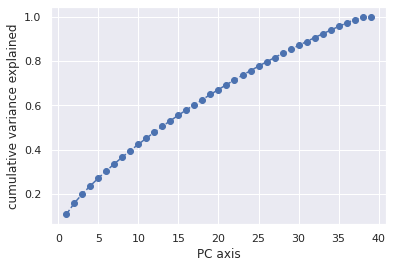

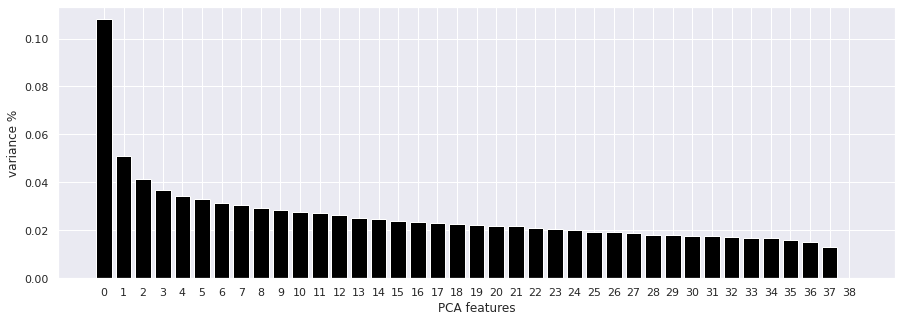

how many components do you want to use?
3

After choosing 3 PCA components: 


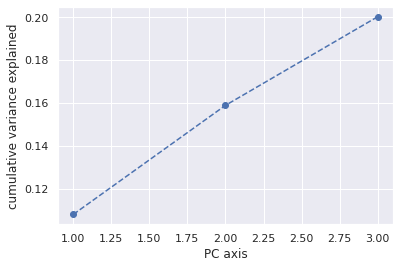

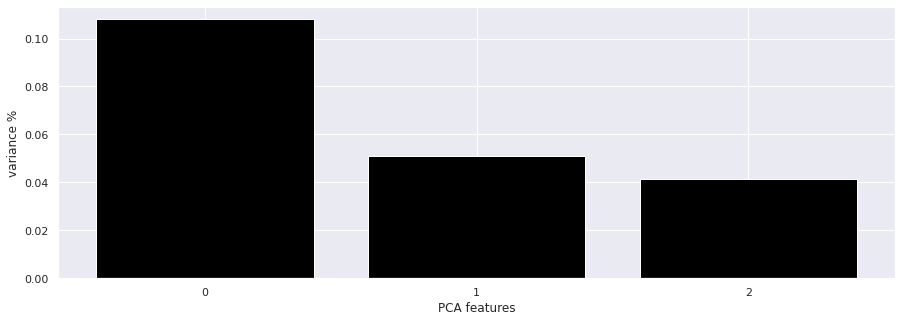

Choosing k ...
For n_clusters = 2 the average silhouette_score is : 0.4671701633573341
For n_clusters = 3 the average silhouette_score is : 0.4283474904211821
For n_clusters = 4 the average silhouette_score is : 0.48597881024665823
For n_clusters = 5 the average silhouette_score is : 0.46175759957687845
For n_clusters = 6 the average silhouette_score is : 0.4470011761349842
For n_clusters = 7 the average silhouette_score is : 0.43208773067396733
For n_clusters = 8 the average silhouette_score is : 0.40672787123775905
For n_clusters = 9 the average silhouette_score is : 0.4195649893460863
For n_clusters = 10 the average silhouette_score is : 0.42746338089793123
For n_clusters = 11 the average silhouette_score is : 0.4388877641592286
For n_clusters = 12 the average silhouette_score is : 0.44290303018077226
For n_clusters = 13 the average silhouette_score is : 0.4283273151680554
For n_clusters = 14 the average silhouette_score is : 0.41484726624806584
For n_clusters = 15 the average silho

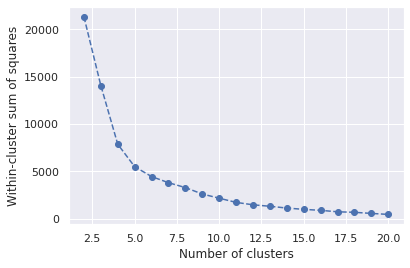

what do you want `k` to be?
4
Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_axes-0-1_poplabels-True.pdf


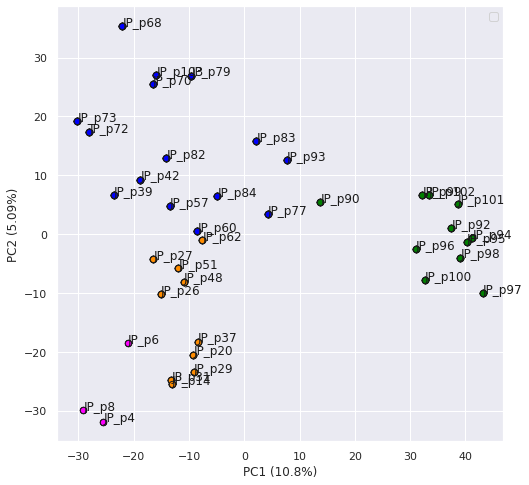

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_axes-0-2_poplabels-True.pdf


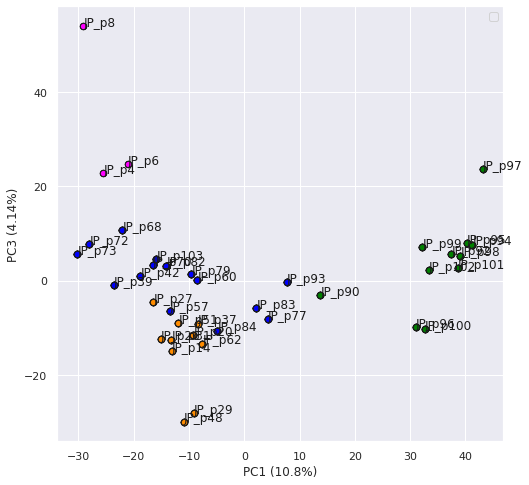

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_axes-1-2_poplabels-True.pdf


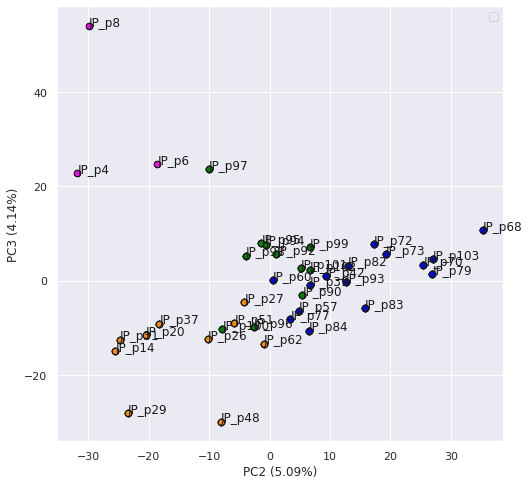

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_map_axes-3_k-4_labels-True.pdf


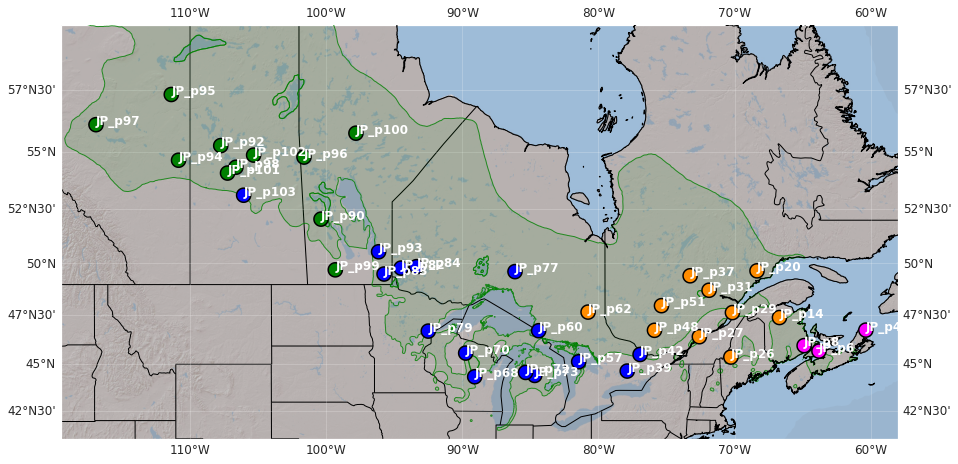

In [12]:
# save figures with labels
nm_data = pipeline(nm_freqs.copy(), label_pops=True, bmkwargs=bmkwargs, basename='no-missing_', saveloc=pcadir)

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_axes-0-1_poplabels-False.pdf


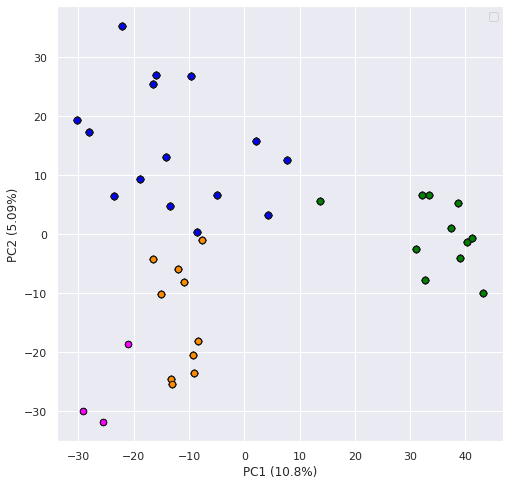

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_axes-0-2_poplabels-False.pdf


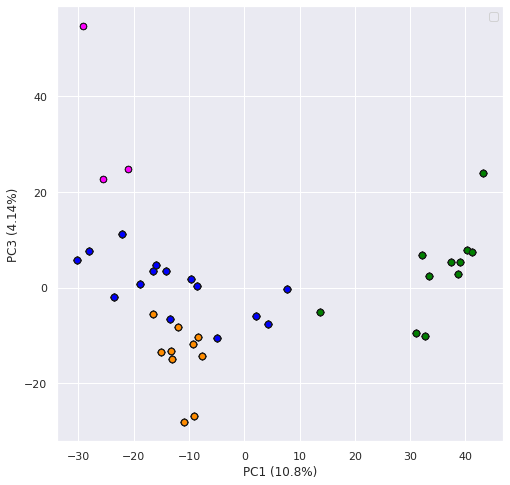

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_axes-1-2_poplabels-False.pdf


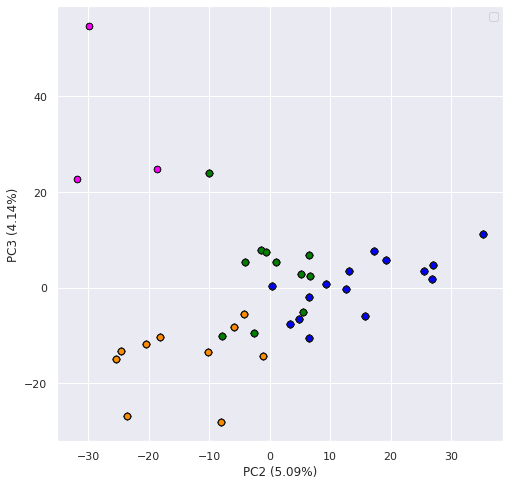

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/no-missing_map_axes-3_k-4_labels-False.pdf


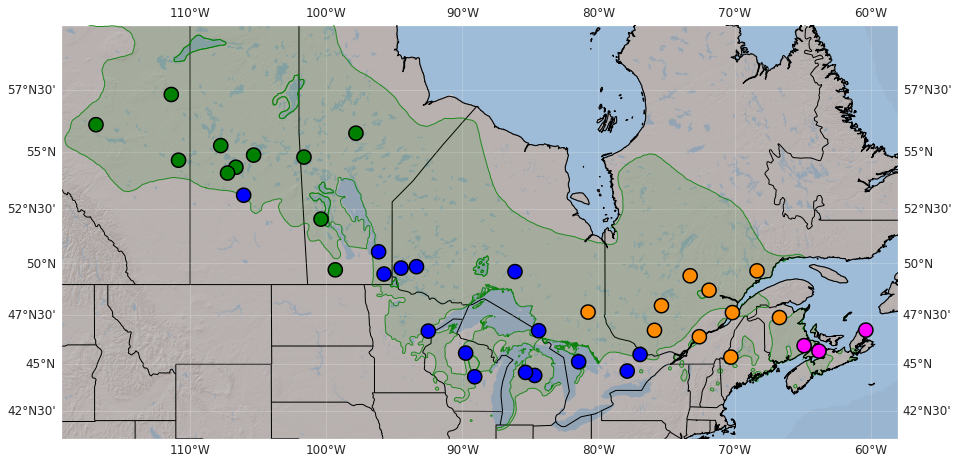

In [13]:
# save figures without labels using n_components and k from above
nm_data_2 = pipeline(nm_freqs.copy(), label_pops=False, bmkwargs=bmkwargs, basename='no-missing_', saveloc=pcadir,
                     n_components=3, k=4, show_variance=False)

### imputed data

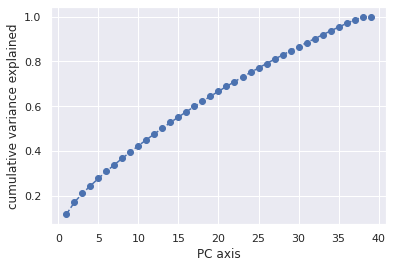

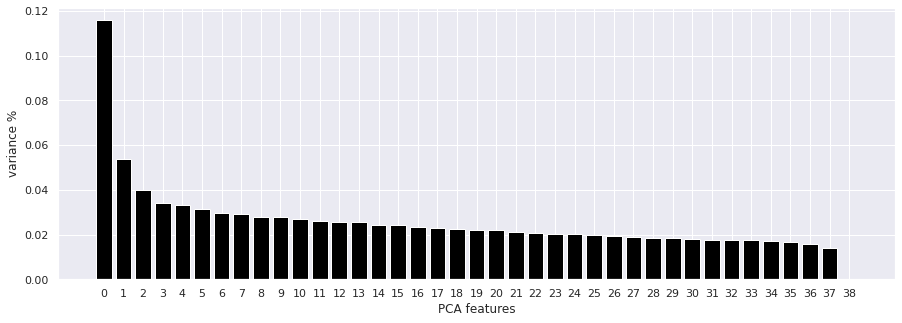

how many components do you want to use?
3

After choosing 3 PCA components: 


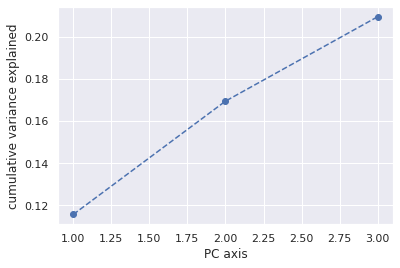

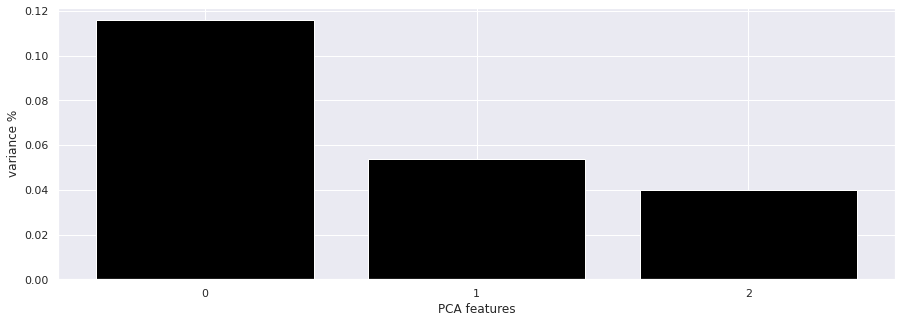

Choosing k ...
For n_clusters = 2 the average silhouette_score is : 0.4696463267974403
For n_clusters = 3 the average silhouette_score is : 0.44974650418181794
For n_clusters = 4 the average silhouette_score is : 0.5107979951526005
For n_clusters = 5 the average silhouette_score is : 0.47958177655305234
For n_clusters = 6 the average silhouette_score is : 0.4697675158167821
For n_clusters = 7 the average silhouette_score is : 0.46480089903897254
For n_clusters = 8 the average silhouette_score is : 0.4561725746300385
For n_clusters = 9 the average silhouette_score is : 0.4589133649823859
For n_clusters = 10 the average silhouette_score is : 0.46210541614467704
For n_clusters = 11 the average silhouette_score is : 0.48493860374473613
For n_clusters = 12 the average silhouette_score is : 0.432454353658341
For n_clusters = 13 the average silhouette_score is : 0.43767182928786
For n_clusters = 14 the average silhouette_score is : 0.4209734602284695
For n_clusters = 15 the average silhouette

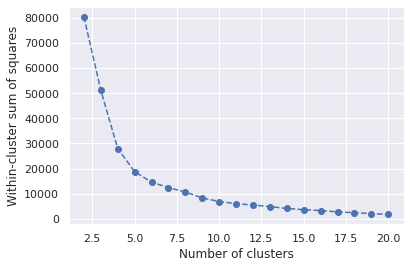

what do you want `k` to be?
4
Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_axes-0-1_poplabels-True.pdf


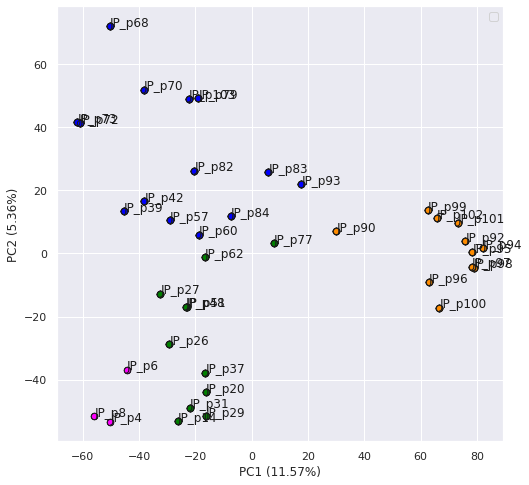

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_axes-0-2_poplabels-True.pdf


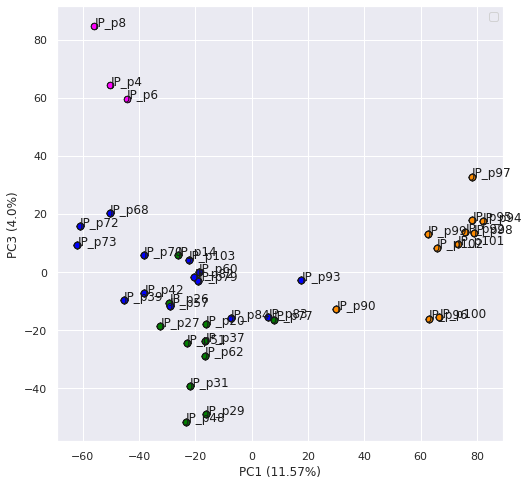

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_axes-1-2_poplabels-True.pdf


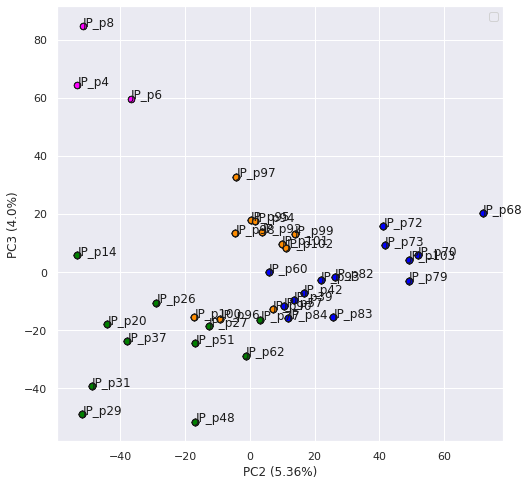

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_map_axes-3_k-4_labels-True.pdf


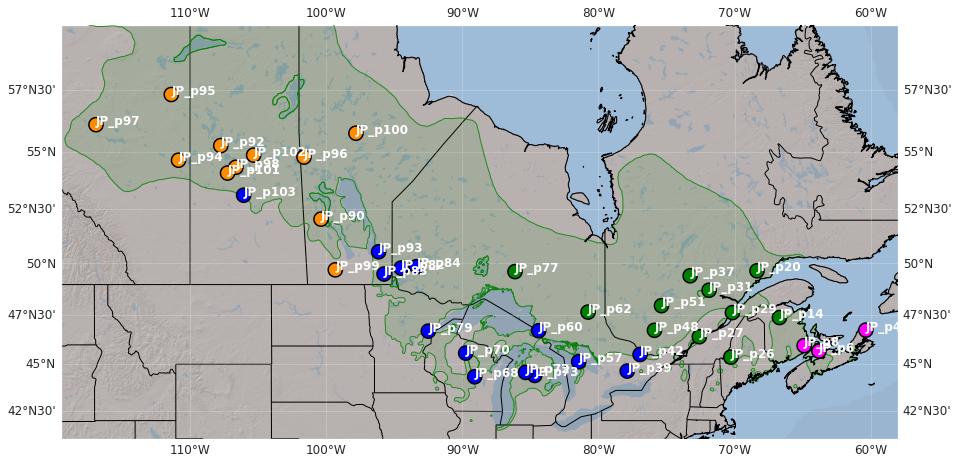

,>super4-15421,>super4-47333,>super4-47418,>super4-47461,>super4-47513,>super4-47541,>super4-47593,>super4-47619,>super4-47629,>super4-47661,>super4-47776,>super4-47803,>super4-47821,>super4-47839,>super4-47872,>super4-47977,>super4-47993,>super4-48065,>super4-48080,>super4-48094,>super4-48231,>super4-48240,>super4-48256,>super4-48318,>super4-48370,>super4-48395,>super4-48403,>super4-48432,>super4-48448,>super4-48682,>super4-48728,>super4-48740,>super4-48743,>super4-48763,>super4-48775,>super4-48777,>super4-48806,>super4-48836,>super4-48856,>super4-48862,>super4-48871,>super4-48890,>super4-48933,>super4-48977,>super4-49096,>super4-49280,>super4-49460,>super4-49591,>super4-49710,>super4-49822,...,>TRINITY_DN153620_c14_g3_i2-215,>TRINITY_DN153620_c14_g3_i2-216,>TRINITY_DN153620_c14_g3_i2-223,>TRINITY_DN153620_c14_g3_i2-235,>TRINITY_DN153620_c14_g3_i2-236,>TRINITY_DN153620_c14_g3_i2-251,>TRINITY_DN153620_c14_g3_i2-257,>TRINITY_DN153620_c14_g3_i2-258,>TRINITY_DN153620_c14_g3_i2-267,>TRINITY_DN153620_c14_g3_i2-268,>TRINITY_DN153620_c14_g3_i2-274,>TRINITY_DN153620_c14_g3_i2-275,>TRINITY_DN153620_c14_g3_i2-291,>TRINITY_DN153620_c14_g3_i2-298,>TRINITY_DN152118_c17_g1_i3-190,>TRINITY_DN152118_c17_g1_i3-223,>TRINITY_DN152118_c17_g1_i3-241,>TRINITY_DN152721_c19_g3_i1-81,>TRINITY_DN152721_c19_g3_i1-114,>TRINITY_DN152721_c19_g3_i1-130,>TRINITY_DN152721_c19_g3_i1-135,>TRINITY_DN152721_c19_g3_i1-138,>TRINITY_DN152721_c19_g3_i1-150,>TRINITY_DN152721_c19_g3_i1-193,>TRINITY_DN160941_c3_g1_i4-25,>TRINITY_DN160941_c3_g1_i4-38,>TRINITY_DN160941_c3_g1_i4-45,>TRINITY_DN160941_c3_g1_i4-55,>TRINITY_DN160941_c3_g1_i4-68,>TRINITY_DN160941_c3_g1_i4-73,>TRINITY_DN160941_c3_g1_i4-74,>TRINITY_DN160941_c3_g1_i4-81,>TRINITY_DN160941_c3_g1_i4-96,>TRINITY_DN160941_c3_g1_i4-101,>TRINITY_DN160941_c3_g1_i4-118,>TRINITY_DN160941_c3_g1_i4-124,>TRINITY_DN160941_c3_g1_i4-125,>TRINITY_DN160941_c3_g1_i4-126,>TRINITY_DN160941_c3_g1_i4-129,>TRINITY_DN160941_c3_g1_i4-151,>TRINITY_DN160941_c3_g1_i4-158,>TRINITY_DN160941_c3_g1_i4-166,>TRINITY_DN160941_c3_g1_i4-178,>TRINITY_DN160941_c3_g1_i4-183,>TRINITY_DN160941_c3_g1_i4-190,Component 1,Component 2,Component 3,Segment K-means PCA,Segment
JP_p98,0.7273,0.1970,0.2000,0.0000,0.5584,0.0000,0.0125,0.9200,0.9565,0.0000,0.1392,0.03585,0.03425,0.1026,0.02740,0.8542,0.0455,0.8261,0.08700,0.6522,1.0000,1.0000,0.8710,0.8780,0.020000,0.154300,0.2326,0.19570,0.7442,0.7105,0.6585,0.023300,0.0698,0.6279,0.243900,0.8750,0.0638,0.23235,0.8444,0.4706,0.078625,0.078400,0.1129,0.8971,0.6765,0.0588,0.1489,0.1304,0.7143,0.6600,...,0.1280,0.3150,0.1301,0.0738,0.2667,0.0685,0.1151,0.3696,0.0538,0.2542,0.0877,0.3913,0.1867,0.2442,0.8000,0.4000,0.7500,0.8333,0.5270,0.7273,0.9091,1.0000,0.9167,0.8333,0.6667,0.7333,0.5263,0.040000,0.3200,0.7917,0.7500,0.0345,0.5667,0.1333,0.6552,0.11215,0.2414,0.0345,0.119375,1.0000,0.3200,0.0589,0.7143,0.7619,0.8333,78.854082,-4.520475,13.220118,2,third
JP_p31,0.8438,0.0909,0.1857,0.0000,0.5639,0.0000,0.0000,0.9516,0.9516,0.0000,0.1081,0.09900,0.09430,0.1048,0.00000,0.9831,0.0000,1.0000,0.07500,0.8286,0.8000,0.9375,0.7368,0.6970,0.160925,0.194275,0.2105,0.29820,0.8214,0.8235,0.8065,0.029875,0.0000,0.7297,0.210675,0.9394,0.0256,0.23910,0.8936,0.6604,0.036400,0.000000,0.1111,0.9189,0.6292,0.1429,0.0556,0.1421,0.7857,0.9355,...,0.1376,0.2930,0.1152,0.0658,0.2425,0.0477,0.1153,0.3961,0.0892,0.2196,0.1145,0.2755,0.2329,0.1701,0.7981,0.3359,0.5849,0.8144,0.3190,0.2385,0.7263,0.8817,0.8454,0.8673,0.8036,0.6230,0.5696,0.033700,0.0800,0.7959,0.7423,0.0270,0.6903,0.2000,0.8018,0.09730,0.2500,0.0523,0.070800,0.9245,0.3524,0.1010,0.7867,0.9306,0.8904,-21.968204,-48.860544,-39.279152,1,second
JP_p93,0.7692,0.2118,0.2577,0.0655,0.3918,0.0000,0.0449,0.9080,0.9070,0.0116,0.1075,0.04210,0.04490,0.0889,0.03900,0.9706,0.0000,1.0000,0.30300,0.5000,0.7857,0.9130,0.7879,0.7556,0.181800,0.215700,0.2353,0.04260,0.7660,0.1905,0.2353,0.043500,0.0426,0.2727,0.325600,0.9535,0.0870,0.55770,0.9231,0.3191,0.063800,0.020400,0.3860,0.9661,0.2714,0.09

In [14]:
# save figures with labels
jpdata = pipeline(freqs.copy(), label_pops=True, bmkwargs=bmkwargs, basename='imputed_', saveloc=pcadir)
jpdata.head()

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_axes-0-1_poplabels-False.pdf


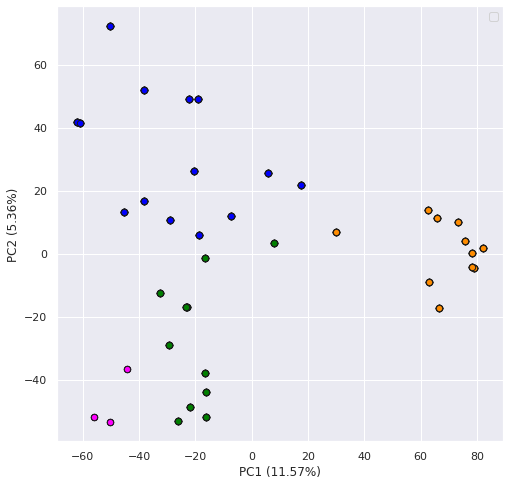

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_axes-0-2_poplabels-False.pdf


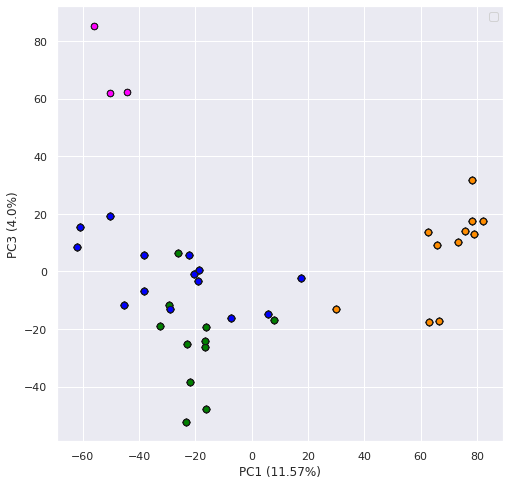

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_axes-1-2_poplabels-False.pdf


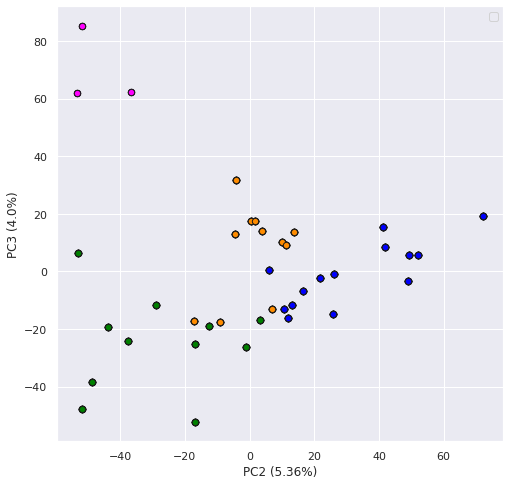

Saved figure to:  /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/without_p24/03_maf-p05_RD-recalculated/pca/imputed_map_axes-3_k-4_labels-False.pdf


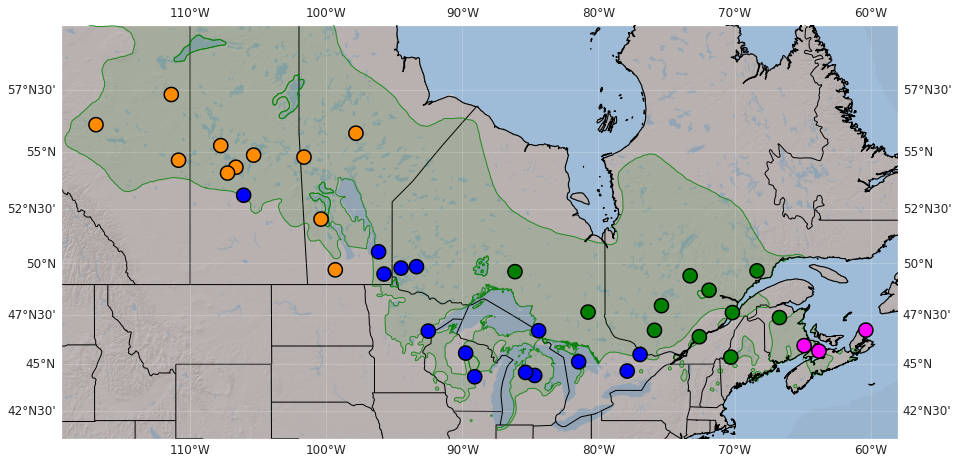

In [15]:
# save figures without labels using n_components and k from above
jpdata_2 = pipeline(freqs.copy(), label_pops=False, bmkwargs=bmkwargs, basename='imputed_', saveloc=pcadir,
                    n_components=3, k=4, show_variance=False)

<a id='save'></a>
# save population group assignments

[top](#home)

In [17]:
# assign color to population in the envdata
popcolors = nm_data['Segment'].map(coldict)
envdata['group_color'] = envdata.index.map(dict(popcolors))
luni(envdata['group_color'])  # should be the number of groups, k, chosen above

4

In [18]:
# after overwriting group colors
envdata.head()

,id1,id2,our_id,LAT,LONG,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group_color
JP_p98,9150251,38,JP_p98,54.3333,-106.6333,537,0.675175,0.520607,-0.903668,1.089738,-0.977280,-0.426821,-0.730607,-0.884497,-1.150172,-1.078601,-0.980098,-1.159142,-0.873067,0.024306,-0.875072,0.771358,0.796677,0.297097,-1.185008,green
JP_p73,3273,22,JP_p73,44.4200,-84.6800,359,0.836472,1.368359,1.495515,-1.369016,1.486357,0.679033,1.970275,1.047245,-0.089609,1.506884,1.449041,0.000330,1.202338,0.909053,-0.778393,0.304132,-1.205688,-0.729581,1.010494,blue
JP_p97,8060006,37,JP_p97,56.1167,-116.9167,636,1.138905,1.382488,-1.202248,0.719680,-0.625332,-0.368618,-0.448998,-1.781378,-1.263664,-0.914443,-0.919871,-1.584282,-1.651344,-0.670852,-0.839916,0.994352,0.436701,0.737103,-2.282760,green
JP_p60,3260,17,JP_p60,46.7200,-84.3900,203,-0.272448,-0.129337,0.093943,-0.869081,0.927381,-0.659632,0.101418,0.495318,0.364358,0.645056,0.907002,0.026096,-0.224503,0.466680,0.320236,-0.311756,-1.093195,0.150429,1.010494,blue
JP_p100,9040116,40,JP_p100,55.7667,-97.8167,205,-0.917638,-0.199983,-1.852100,2.404514,-1.743285,-0.135807,-1.831440,-2.333304,-0.974064,-2.350824,-1.943723,-1.030312,-1.456774,-2.693131,-0.330152,0.293514,1.674118,2.497123,-1.843659,green


In [19]:
# save envdata with new colors
envdata.to_csv(envfile, index=False, sep='\t')

[top](#home)